# Using ``pypbomb``

Let's go over some quick examples of how you might use ``pypbomb`` to design a detonation tube for your research.

In [1]:
from itertools import product
import warnings

import cantera as ct
import numpy as np
import pandas as pd
import pint
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

from pypbomb import tube

ureg = pint.UnitRegistry()
quant = ureg.Quantity

## Determine tube size and operating limits

First we will pick a mixture of stoichiometric propane/air. For this example we will use ``gri30.cti`` as the mechanism of choice for our Cantera calculations.

In [2]:
fuel = "C3H8"
oxidizer = "O2:1 N2:3.76"
material = "316L"
mechanism = "gri30.cti"
gas = ct.Solution(mechanism)
gas.set_equivalence_ratio(1, fuel, oxidizer)

Next, let's consider 316L since it's a commonly used stainless steel.

In [3]:
material = "316L"

At this point we should probably out which schedules are available across all of the potential pipe sizes that we'd like to consider.

In [4]:
potential_sizes = ["1", "4", "6", "8"]
common_sizes = set(tube.Tube.get_available_pipe_schedules(potential_sizes[0]))
for size in potential_sizes[1:]:
    common_sizes.intersection_update(
        set(tube.Tube.get_available_pipe_schedules(size))
    )
common_sizes

{'10', '10s', '160', '40', '40s', '5', '5s', '80', '80s', 'XXH'}

Given these options, let's choose schedules 40, 80, 120, and XXH for consideration.

In [5]:
potential_schedules = ["40", "80", "XXH"]

Let's also look at a couple of different operating temperatures. Room temperature is always a good place to start. We will also look at 100 degrees Celsius; perhaps we want to use a hot water jacket to investigate detonations at elevated initial temperatures, so let's use 100 degrees as well.

rewrite this to suck less

In [6]:
initial_temperatures = quant(
    np.linspace(20, 400, 6),
    "degC"
)

Now let's figure out what we can do with each combination of pipe size, pipe schedule, and initial temperature. The steps we will use for each combination are:

1. look up the tube dimensions,
2. look up the maximum allowable stress,
3. calculate the corresponding maximum pressure,
4. look up the elastic modulus, density, and Poisson ratio of our tube material, and
5. calculate the maximum safe initial pressure that we can test at.

Note that we are setting ``multiprocessing=False``, since multiprocessing can cause unexpected misbehavior when run from within a jupyter notebook.

In [7]:
calculate_results = False
results_file = "tube_size_results.h5"

combinations = list(
    product(
        potential_schedules,
        potential_sizes,
        initial_temperatures
    )
)
if calculate_results:
    results = pd.DataFrame(
        columns=[
            "schedule",
            "size",
            "max initial pressure (psi)",
            "initial temperature (F)",
            "tube_temp",
            "max_pressure",
        ]
    )
    for i, (schedule, size, initial_temperature) in enumerate(combinations):
        dims = tube.Tube.get_dimensions(
            size,
            schedule,
            unit_registry=ureg
        )
        max_stress = tube.Tube.calculate_max_stress(
            initial_temperature,
            material,
            welded=False,
            unit_registry=ureg
        )
        max_pressure = tube.Tube.calculate_max_pressure(
            dims["inner_diameter"],
            dims["outer_diameter"],
            max_stress
        )
        elastic_modulus = tube.Tube.get_elastic_modulus(material, ureg)
        density = tube.Tube.get_density(material, ureg)
        poisson = tube.Tube.get_poisson(material)
        initial_pressure = tube.Tube.calculate_max_initial_pressure(
            dims["inner_diameter"],
            dims["outer_diameter"],
            initial_temperature,
            gas.mole_fraction_dict(),
            mechanism,
            max_pressure.to("Pa"),
            elastic_modulus,
            density,
            poisson,
            use_multiprocessing=False
        )

        current_results = pd.Series(dtype="object")
        current_results["schedule"] = schedule
        current_results["size"] = size
        current_results["max initial pressure (psi)"] = \
        initial_pressure.to("psi").magnitude
        current_results["initial temperature (F)"] = \
            initial_temperature.to("degF").magnitude
        current_results["tube_temp"] = initial_temperature
        current_results["max_pressure"] = max_pressure
        current_results["inner_diameter"] = dims["inner_diameter"]
        results = pd.concat(
            (results, current_results.to_frame().T),
            ignore_index=True
        )
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        with pd.HDFStore(results_file, "w") as store:
            store.put("data", results)

else:
    with pd.HDFStore(results_file, "r") as store:
        results = store.data

o wow do the plot thign cool

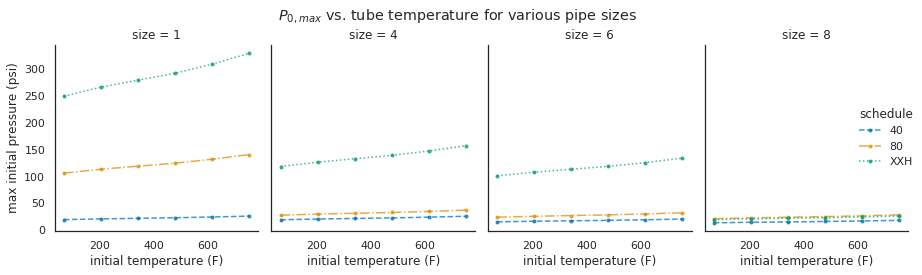

In [28]:
sns.set_context("notebook")
sns.set_style("white")
g = sns.FacetGrid(
    col="size",
    hue="schedule",
    data=results,
    height=4,
    aspect=0.75,
    palette="colorblind",
    hue_kws=dict(linestyle=["--", "-.", ":"])
)
g.map(
    plt.plot,
    "initial temperature (F)",
    "max initial pressure (psi)",
    alpha=0.75,
    marker="."
).add_legend()
plt.suptitle("$P_{0,max}$ vs. tube temperature for various pipe sizes")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
sns.despine()


o wow say neat things and investigate DLF to show that it's why thigns collapse as size goes up

In [9]:
results_main = results[
    (results["size"] == "6") &
    (results["schedule"] == "80")
].drop(
    ["max initial pressure (psi)",
     "initial temperature (F)"],
    axis=1
)
results_main

,schedule,size,tube_temp,max_pressure,inner_diameter
36,80,6,20.0 degree_Celsius,2.1903439367027286 kip_per_square_inch,5.761 inch
37,80,6,96.0 degree_Celsius,1.846139060229291 kip_per_square_inch,5.761 inch
38,80,6,172.0 degree_Celsius,1.5963561440335863 kip_per_square_inch,5.761 inch
39,80,6,248.0 degree_Celsius,1.4192312611012432 kip_per_square_inch,5.761 inch
40,80,6,324.0 degree_Celsius,1.3029337639270142 kip_per_square_inch,5.761 inch
41,80,6,400.0 degree_Celsius,1.2265926045535283 kip_per_square_inch,5.761 inch


mixing section

In [10]:
results_mix = results[
    (results["size"] == "1") &
    (results["schedule"] == "40")
].drop(
    ["max initial pressure (psi)",
     "initial temperature (F)",
     "inner_diameter"],
    axis=1
)
results_mix["max_main_pressure"] = results_main["max_pressure"].values
results_mix["safe"] = (results_mix["max_pressure"] > 
                       results_mix["max_main_pressure"])
if all(results_mix["safe"]):
    print("Mix tube is safe :)")
else:
    print("Mix tube is unsafe :(")
results_mix

Mix tube is safe :)


,schedule,size,tube_temp,max_pressure,max_main_pressure,safe
0,40,1,20.0 degree_Celsius,3.5331641285956006 kip_per_square_inch,2.1903439367027286 kip_per_square_inch,True
1,40,1,96.0 degree_Celsius,2.9779397631133677 kip_per_square_inch,1.846139060229291 kip_per_square_inch,True
2,40,1,172.0 degree_Celsius,2.5750240270727587 kip_per_square_inch,1.5963561440335863 kip_per_square_inch,True
3,40,1,248.0 degree_Celsius,2.289310321489002 kip_per_square_inch,1.4192312611012432 kip_per_square_inch,True
4,40,1,324.0 degree_Celsius,2.1017150592216587 kip_per_square_inch,1.3029337639270142 kip_per_square_inch,True
5,40,1,400.0 degree_Celsius,1.9785719120135372 kip_per_square_inch,1.2265926045535283 kip_per_square_inch,True


## Select proper flanges

### Main section

In [11]:
results_main["flange class"] = results_main.apply(
    lambda x: tube.Flange.get_class(
        x["max_pressure"],
        x["tube_temp"],
        material,
        ureg
    ),
    axis=1
)
results_main["flange class"].max()

'1500'

### Mixing section

In [12]:
results_mix["flange class"] = results_mix.apply(
    lambda x: tube.Flange.get_class(
        x["max_main_pressure"],
        x["tube_temp"],
        material,
        ureg
    ),
    axis=1
)
results_mix["flange class"].max()

'1500'

## Determine window dimensions and bolt pattern

### Window Dimensions

blah blah viewing window unclamped height = 5.75 inches blah blah

In [13]:
window_height = quant(5.75, "in")
window_lengths = np.linspace(0.25, 7, 100)
window_thicknesses = tube.Window.minimum_thickness(
    length=window_height,
    width=quant(window_lengths, "in"),
    safety_factor=4,
    pressure=results_main["max_pressure"].max(),
    rupture_modulus=(197.9, "MPa"),
    unit_registry=ureg
).to("in").magnitude

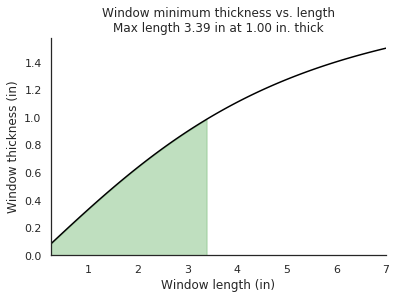

In [14]:
max_desired_thickness = 1  # inch
plt.plot(window_lengths, window_thicknesses, "k")
plt.fill_between(
    window_lengths[window_thicknesses <= max_desired_thickness],
    window_thicknesses[window_thicknesses <= max_desired_thickness], 
    0,
    color="g",
    alpha=0.25,
    zorder=-1
)
plt.xlim([window_lengths.min(), window_lengths.max()])
plt.ylim([0, plt.ylim()[1]])
plt.xlabel("Window length (in)")
plt.ylabel("Window thickness (in)")
plt.title(
    "Window minimum thickness vs. length\n"
    "Max length {:3.2f} in at {:3.2f} in. thick".format(
        window_lengths[window_thicknesses <= max_desired_thickness].max(),
        max_desired_thickness
    )
)
sns.despine()

let's go with a 2.25 inch window (due to camera limitations), and 1 inch thick. what's the safety factor?

In [15]:
window_length = quant(2.25, "in")
tube.Window.safety_factor(
    window_length,
    window_height,
    quant(1, "in"),
    pressure=results_main["max_pressure"].max(),
    rupture_modulus=quant(197.9, "MPa"),    
)

7.95962038236468

### Bolt pattern

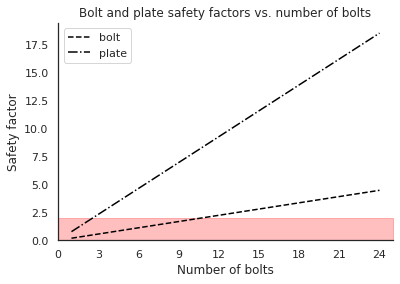

In [30]:
num_bolts = np.array(range(1, 25))
bolt_safety_factors = tube.Bolt.calculate_safety_factors(
    max_pressure=results_main["max_pressure"].max(),
    window_area = window_length * window_height,
    num_bolts=num_bolts,
    thread_size="1/4-28",
    thread_class="2",
    bolt_max_tensile=(150, "kpsi"),  # grade 8
    plate_max_tensile=(485, "MPa"),  # 316L,
    engagement_length=(0.5, "in"),
    unit_registry=ureg
)

fig, ax = plt.subplots()
ax.plot(
    num_bolts, 
    bolt_safety_factors["bolt"],
    "k--",
    label="bolt"
)
ax.plot(
    num_bolts, 
    bolt_safety_factors["plate"],
    "k-.",
    label="plate"
)
    
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend()
ax.set_ylim([0, ax.get_ylim()[1]])
ax.set_xlim([num_bolts.min()-1, num_bolts.max()+1])
ax.set_xlabel("Number of bolts")
ax.set_ylabel("Safety factor")
ax.set_title("Bolt and plate safety factors vs. number of bolts")
ax.fill_between(
    ax.get_xlim(), 
    2,
    zorder=-1,
    color="r",
    alpha=0.25,
)
sns.despine()

important: bolt safety factor < plate safety factor

## Estimate DDT length

In [ ]:
tube.DDT.

## Find safe operation limits for a new mixture